In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [2]:
data_dir = 'ml-1m'

movies_filename = 'movies.dat'
users_filename = 'users.dat'
ratings_filename = 'ratings.dat'

movies_columns = ['MovieID', 'Title', 'Genres']
users_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
ratings_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

def create_dataframe(data_dir, filename, columns):
    data_file = os.path.join(data_dir, filename)
    return pd.read_csv(data_file, delimiter='::', names=columns, encoding='latin-1', engine='python')

movies = create_dataframe(data_dir, movies_filename, movies_columns)
users = create_dataframe(data_dir, users_filename, users_columns)
ratings = create_dataframe(data_dir, ratings_filename, ratings_columns)
data = (users, movies, ratings)

In [3]:
def rating_error(test_set, model, subset:int=None):
    if subset is not None:
        actual_ratings = test_set[:subset]['Rating']
        predicted_ratings = test_set[:subset].apply(model, axis=1)
    else:
        actual_ratings = test_set['Rating']
        predicted_ratings = test_set.apply(model, axis=1)

    rating_error = (((actual_ratings - predicted_ratings)**2)**(1/2)).mean()
    return rating_error

In [4]:
# Overall mean rating 
mean_rating = ratings['Rating'].mean()

# Lookup tables for naive models 2, 3, 4 and 5
mean_rating_per_user = {user_id : ratings[ratings['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
mean_rating_per_movie = {movie_id : ratings[ratings['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}

In [5]:
def test_naive_model_1(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors = np.array([])
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        mean_rating = train_set['Rating'].mean()
        
        def model(row):
            return mean_rating
        
        rating_err = rating_error(test_set, model, subset)
        print(rating_err)
        
        rating_errors = np.append(rating_errors, rating_err)
    return rating_errors

errors = test_naive_model_1(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

0.935986633921368
0.9326130200574327
0.9328028300165171
0.9342782982805649
0.9336288110062256
mean error 0.9338619186564217


In [6]:
def test_naive_model_2(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors = np.array([])
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        movie_ids = train_set['MovieID']
        mean_rating_per_movie = {movie_id : train_set[train_set['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}
        
        def model(row):
            movie_id = row['MovieID']
            return mean_rating_per_movie[movie_id]
        
        rating_err = rating_error(test_set, model, subset)
        print(rating_err)
        
        rating_errors = np.append(rating_errors, rating_err)
    return rating_errors

errors = test_naive_model_2(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

0.7851107461333201
0.7811089925858026
0.7799034947667455
0.7818160318057912
0.7831246014171904
mean error 0.78221277334177


In [7]:
def test_naive_model_3(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors = np.array([])
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        user_ids = train_set['UserID']
        mean_rating_per_user = {user_id : train_set[train_set['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
        
        def model(row):
            user_id = row['UserID']
            return mean_rating_per_user[user_id]
        
        rating_err = rating_error(test_set, model, subset)
        print(rating_err)
        
        rating_errors = np.append(rating_errors, rating_err)
    return rating_errors

errors = test_naive_model_3(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

0.8329949719978802
0.8266677994054135
0.8281312090560236
0.828891912964882
0.8280632808182781
mean error 0.8289498348484955


In [8]:
def test_error_4_5(test_set,reg):
    
    mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in test_set['MovieID']])
    mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in test_set['UserID']])
    
    ##the predicted rating value for the test set using model 4 and 5.
    mean_rating_list = np.vstack((mean_rating_per_movie_list,mean_rating_per_user_list)).T
    pre_rating = reg.predict(mean_rating_list)[0]
    
    rating_error = (((test_set['Rating'] - pre_rating)**2)**(1/2)).mean()
    
    return rating_error
    
    

In [9]:
def test_naive_model_4_5(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors_4 = np.array([])
    rating_errors_5 = np.array([])
    
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        user_ids = train_set['UserID']
        
        mean_rating_per_movie = {movie_id : train_set[train_set['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}
        mean_rating_per_user = {user_id : train_set[train_set['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
        
        
        ##the lists of mean Ritem and mean Ruser for each rating in the train_set
        mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in train_set['MovieID']])
        mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in train_set['UserID']])
        
        ## stack the Ritem and Ruser lists for linear fitting
        mean_rating_list = np.vstack((mean_rating_per_movie_list, mean_rating_per_user_list)).T
        
        ## uisng Ordinary least squares Linear Regression to find alpha beta and gamma
        reg_4 = LinearRegression(fit_intercept=False).fit(mean_rating_list, train_set['Rating'])
        reg_5 = LinearRegression(fit_intercept=True).fit(mean_rating_list, train_set['Rating'])

        
        rating_err_4 = test_error_4_5(test_set,reg_4)
        rating_err_5 = test_error_4_5(test_set,reg_5)
        
        rating_errors_4 = np.append(rating_errors_4,rating_err_4)
        rating_errors_5 = np.append(rating_errors_5,rating_err_5)
        
        print('Rating Error for Naive Model 4:', rating_err_4)
        print('Rating Error for Naive Model 5:', rating_err_5)
    
    print('Mean Rating Error for Naive Model 4:', np.mean(rating_errors_4))   
    print('Mean Rating Error for Naive Model 5:', np.mean(rating_errors_5))
        
        
        

In [10]:
test_naive_model_4_5(data)

Rating Error for Naive Model 4: 1.061734266640631
Rating Error for Naive Model 5: 1.2885178881759964
Rating Error for Naive Model 4: 0.9610577067705951
Rating Error for Naive Model 5: 1.1533333933063303
Rating Error for Naive Model 4: 0.9797571412885032
Rating Error for Naive Model 5: 1.1785465747294663
Rating Error for Naive Model 4: 0.9078356828163895
Rating Error for Naive Model 5: 0.877873484900148
Rating Error for Naive Model 4: 0.8764768455823497
Rating Error for Naive Model 5: 1.036442648874387
Mean Rating Error for Naive Model 4: 0.9573723286196938
Mean Rating Error for Naive Model 5: 1.1069427979972657


In [11]:
a = np.array([1,2,3])
b = np.array([4,5,6])

c = np.vstack((a,b)).T

c

array([[1, 4],
       [2, 5],
       [3, 6]])

[0.70244231]
0.5931777282216044
0.33897363889887067


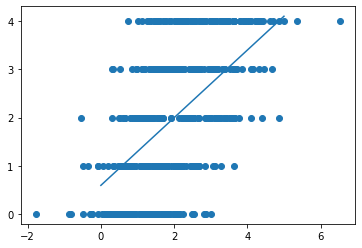

In [12]:
# print(reg_4.coef_, reg_4.intercept_)
# print(reg_5.coef_, reg_5.intercept_)

# fig = plt.figure(figsize = (8, 8))
# ax = plt.axes(projection ="3d")
# ax.scatter3D(mean_rating_per_movie_list, train_set['Rating'], mean_rating_per_user_list, c=train_set['Rating'], s=0.01)
# x = np.linspace(3.0, 4.0, 100)
# y = np.linspace(0.0, 5.0, 10)
# X, Y = np.meshgrid(x, y)
# ax.scatter3D(X, Y, reg_4.coef_[0] * X + reg_4.coef_[1] * Y + reg_4.intercept_, s=0.1)
# ax.scatter3D(X, Y, reg_5.coef_[1] * X + reg_5.coef_[0] * Y + reg_5.intercept_, s=1.0)
# ax.view_init(0, -190)
# plt.show()

# x = np.linspace(0.0, 5.0, 100)
# e = np.random.normal(0, 0.5, 100)
# y = 0.7 * x - 0.3

x = np.array([])
y = np.array([])

for i in np.arange(5):
    x = np.concatenate((x, np.random.normal(1.0 + i * 0.5, 1.0, 100)))
    y = np.concatenate((y, i * np.ones(100)))

lin_reg = LinearRegression(fit_intercept=True).fit(x[..., None], y)

a = lin_reg.coef_[0]
b = lin_reg.intercept_

print(lin_reg.coef_)
print(lin_reg.intercept_)
print(lin_reg.score(x[..., None], y))

plt.plot(np.linspace(0, 5, 100), a * np.linspace(0, 5, 100) + b)
plt.scatter(x, y)
plt.show()